In [41]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical intel prices
In this notebook, you will load historical intel price data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [42]:
# Futures contract on the Yen-dollar exchange rate:

intel = pd.read_csv(
    Path("intel.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)

intel.head()

,Close,Volume,Open,High,Low
Date,,,,,
2014-12-16,35.56,30978640.0,35.86,36.50,35.56
2014-12-17,36.24,31596790.0,35.62,36.33,35.33
2014-12-18,37.02,32069660.0,36.75,37.02,36.43
2014-12-19,36.37,76721940.0,37.02,37.16,36.23
2014-12-22,37.21,29193180.0,36.39,37.26,36.39


In [43]:
# Trim the dataset to begin on December 15th, 2015
intel = intel.loc["2014-12-15":, :]
intel.head(500)


,Close,Volume,Open,High,Low
Date,,,,,
2014-12-16,35.56,30978640.0,35.86,36.50,35.56
2014-12-17,36.24,31596790.0,35.62,36.33,35.33
2014-12-18,37.02,32069660.0,36.75,37.02,36.43
2014-12-19,36.37,76721940.0,37.02,37.16,36.23
2014-12-22,37.21,29193180.0,36.39,37.26,36.39
...,...,...,...,...,...
2016-12-02,34.16,21490830.0,33.72,34.26,33.60
2016-12-05,34.39,14454670.0,34.31,34.42,33.97
2016-12-06,34.72,15297180.0,34.39,34.75,34.30


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Close/Last" price. Do you see any patterns, long-term and/or short?

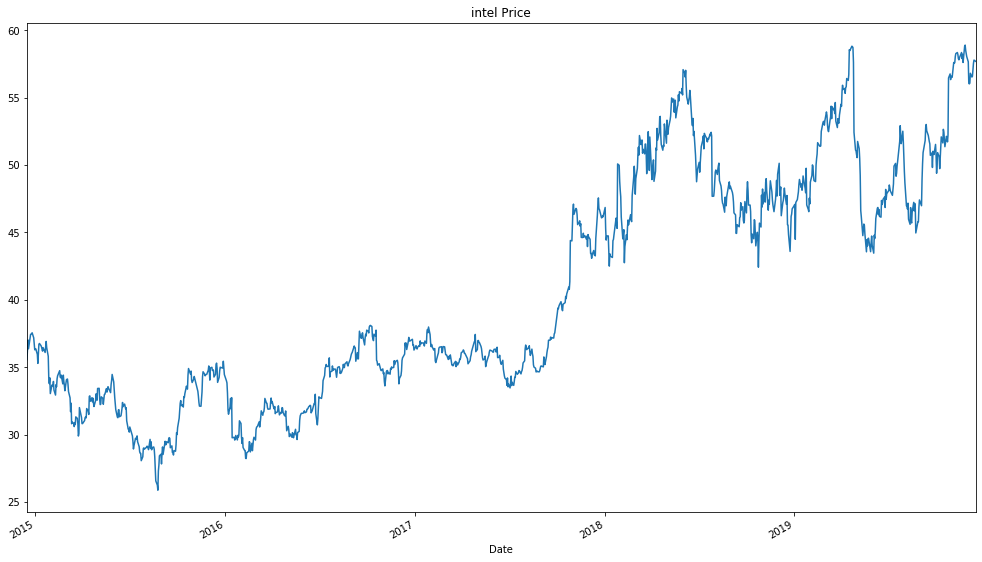

In [44]:
# Plot just the "Close/Last" column from the dataframe:
intel['Close'].plot(figsize=(17, 10), title="intel Price")

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the intel prices. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [45]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Close" price into two separate series:
intel_noise, intel_trend = sm.tsa.filters.hpfilter(intel['Close'])

In [46]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
intel_decomp = intel[["Close"]].copy()
intel_decomp["noise"] = intel_noise
intel_decomp["trend"] = intel_trend
intel_decomp.head()

,Close,noise,trend
Date,,,
2014-12-16,35.56,-1.262609,36.822609
2014-12-17,36.24,-0.579768,36.819768
2014-12-18,37.02,0.203862,36.816138
2014-12-19,36.37,-0.440567,36.810567
2014-12-22,37.21,0.407969,36.802031


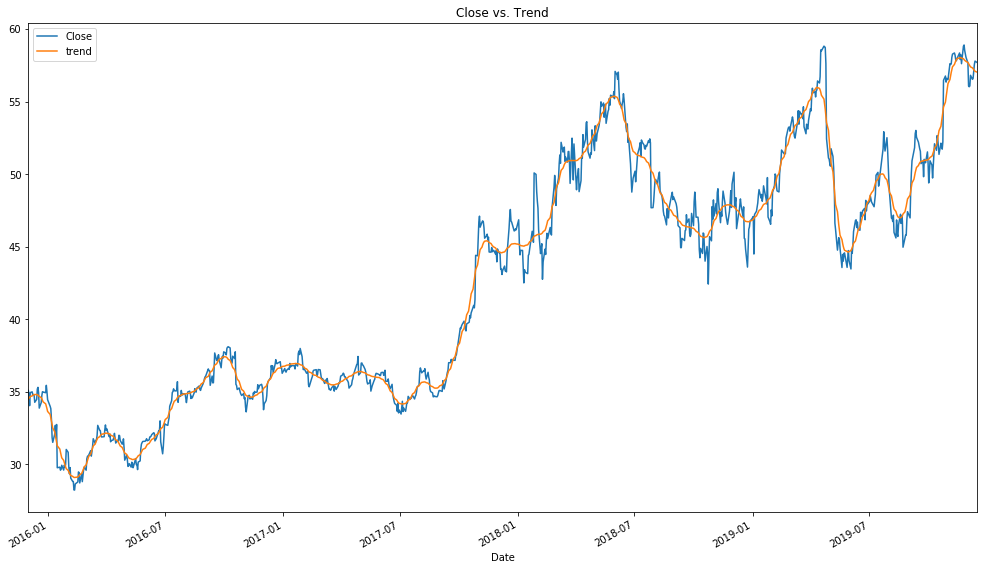

In [47]:
# Plot the Settle Price vs. the Trend
intel_decomp[["Close", "trend"]]["2015-12-01":].plot(figsize=(17, 10), title="Close vs. Trend")

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

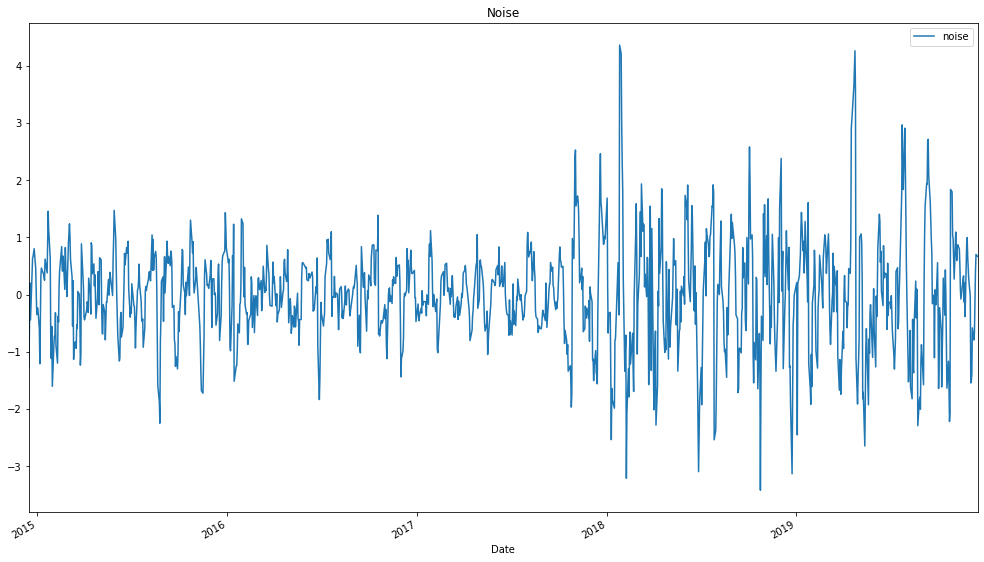

In [48]:
# Plot the Settle Noise
intel_decomp[["noise"]].plot(figsize=(17, 10), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [49]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (intel[["Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Close
Date,
2019-12-10,0.106138
2019-12-11,0.848206
2019-12-12,0.841072
2019-12-13,0.417029
2019-12-16,-0.155736


In [50]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [51]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:                     ARMA(2, 1)   Log Likelihood               -2387.016
Method:                       css-mle   S.D. of innovations              1.614
Date:                Fri, 20 Dec 2019   AIC                           4784.033
Time:                        22:06:13   BIC                           4809.719
Sample:                             0   HQIC                          4793.686
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0515      0.043      1.203      0.229      -0.032       0.135
ar.L1.y       -0.8006      0.341     -2.347      0.019      -1.469      -0.132
ar.L2.y       -0.0584      0.029     -2.021      0.044      -0.115      -0.002
ma.L1.y        0.7483      0.341      2.196      0.028       0.080       1.416
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3898           +0.0000j            1.3898            0.5000
AR.2          -12.3259           +0.0000j           12.3259            0.5000
MA.1           -1.3364           +0.0000j            1.3364            0.5000
-----------------------------------------------------------------------------
"""

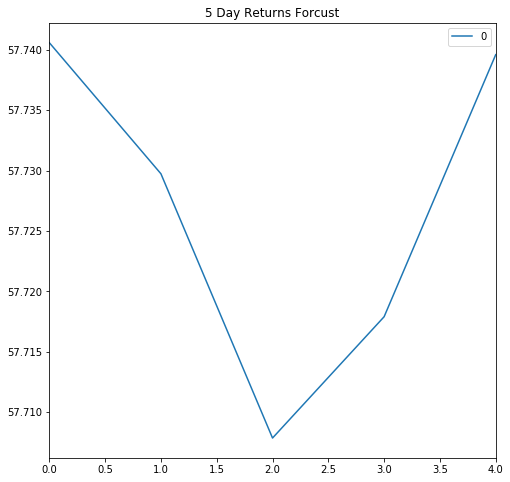

In [65]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(8, 8), title="5 Day Returns Forcust")

## Question:

#### Based on the p-value, is the model a good fit?

## Answer:

#### Based on the p-value, the model is not a good fit.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [53]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(intel["Close"], order=(5, 1, 1))


# Fit the model
results = model.fit()

C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [54]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1258
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -1328.930
Method:                       css-mle   S.D. of innovations              0.696
Date:                Fri, 20 Dec 2019   AIC                           2673.859
Time:                        22:06:15   BIC                           2714.957
Sample:                             1   HQIC                          2689.304
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0175      0.018      0.948      0.343      -0.019       0.054
ar.L1.D.Close    -0.0574      0.287     -0.200      0.842      -0.621       0.506
ar.L2.D.Close     0.0097      0.032      0.306      0.760      -0.053       0.072
ar.L3.D.Close     0.0650      0.028      2.307      0.021       0.010       0.120
ar.L4.D.Close    -0.0258      0.034     -0.767      0.444      -0.092       0.040
ar.L5.D.Close    -0.0615      0.029     -2.131      0.033      -0.118      -0.005
ma.L1.D.Close     0.0048      0.287      0.017      0.987      -0.558       0.568
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4381           -0.9816j            1.7412           -0.0953
AR.2            1.4381           +0.9816j            1.7412            0.0953
AR.3           -0.6778           -1.5175j            1.6620           -0.3169
AR.4           -0.6778           +1.5175j            1.6620            0.3169
AR.5           -1.9405           -0.0000j            1.9405           -0.5000
MA.1         -207.5020           +0.0000j          207.5020            0.5000
-----------------------------------------------------------------------------
"""

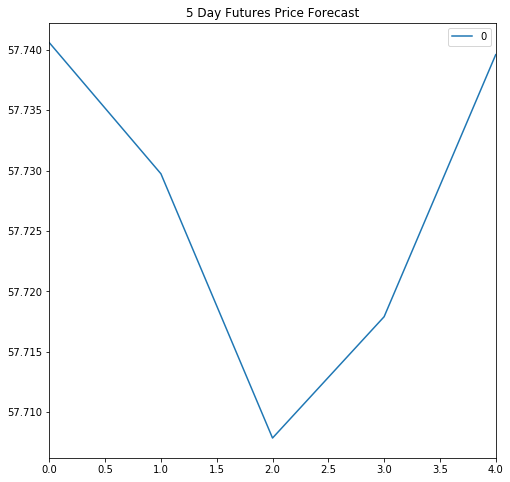

In [55]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(8, 8), title="5 Day Futures Price Forecast")

### What does the model forecast will happen to the intel price in the near term?

### Based on model forcast the intel stock price will go down in value

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [56]:
import arch as arch
from arch import arch_model

In [57]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1, rescale=False)

# Fit the model
res = model.fit(disp="off")

In [58]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2351.89
Distribution:                  Normal   AIC:                           4711.78
Method:            Maximum Likelihood   BIC:                           4732.33
                                        No. Observations:                 1258
Date:                Fri, Dec 20 2019   Df Residuals:                     1254
Time:                        22:06:15   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0192  3.177e-02      0.606      0.545 [-4.303e-02,8.153e-02]
alpha[1]       0.0205  7.366e-02      0.278      0.781      [ -0.124,  0.165]
alpha[2]       0.0000  7.537e-02      0.000      1.000      [ -0.148,  0.148]
beta[1]        0.9723  2.594e-02     37.490 1.322e-307      [  0.921,  1.023]
=============================================================================

Covariance estimator: robust
"""

In [59]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-12-16'

In [60]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [61]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.tail()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-12-16,23.464086,23.483315,23.502391,23.521315,23.540088


In [62]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-12-16
h.1,23.464086
h.2,23.483315
h.3,23.502391
h.4,23.521315
h.5,23.540088


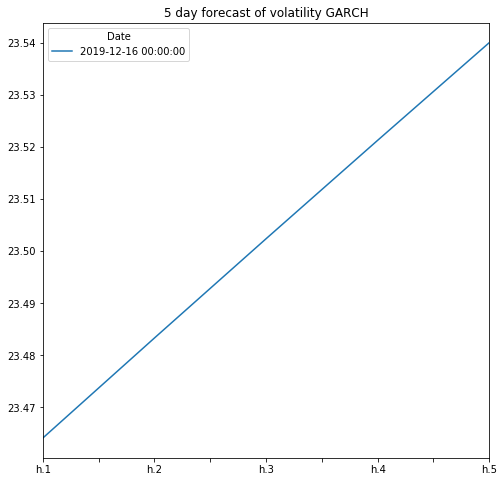

In [63]:
# Plot the final forecast
final.plot(figsize=(8, 8), title="5 day forecast of volatility GARCH")

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

2. Is the risk of the yen expected to increase or decrease?

3. Based on the model evaluation, would you feel confident in using these models for trading?

1. Based on time series analysis I would by the yen now.

2. Yes, the risk expected to increase.

3. Based on the model evaluation, I feel confident uding only GARCH model for trading. ARMA and ARIMA are not good fit.